# ML Supervisado: Random Forest y predicción de Enfermedad pulmonar obstructiva crónica

A lo largo del proyecto, hemos observado que la variable 'coad' está asociada al tratamiento placebo, y no está relacionada con otros efectos adversos. Mediante análisis de clustering, fue posible identificar grupos de variables con características similares, lo que, en combinación con el conocimiento biomédico disponible, nos permite optimizar la selección de variables para implementar un modelo de Random Forest, una técnica de aprendizaje supervisado.

El Random Forest, es un algoritmo tipo ensemble, que utiliza las predicciones generadas por múltiples árboles de decisión, donde la predicción final se determina mediante la votación mayoritaria de todos los árboles participantes. Es importante señalar que **obtener una predicción balanceada (que sea precisa y sensible) representa un desafío significativo**, principalmente debido a la alta prevalencia de valores NaN en el dataset. Además, la variable 'coad' probablemente muestra correlaciones complejas con múltiples factores no registrados en este conjunto de datos, incluyendo factores genéticos, ambientales y relacionados con hábitos personales.

No obstante a estas limitaciones, el análisis proporciona información valiosa a través del atributo **feature_importances_**, que nos permite identificar las variables predictoras que más contribuyen a las decisiones del Random Forest. Esta información resulta fundamental para comprender los factores más influyentes en el fenómeno estudiado y puede guiar futuras investigaciones.

In [1]:
#Importamos las librerías necesarias; xgboost se usará más adelante.
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.tree import plot_tree

warnings.filterwarnings('ignore')


## GridSearch y ajuste de hiperparámetros

Realizaremos un ajuste de hiperparámetros utilizando las observaciones de la semana 8. El GridSearch evalúa sistemáticamente **todas las combinaciones posibles de hiperparámetros del RandomForestClassifier y devuelve la configuración óptima**. Es importante mencionar que este proceso implica un elevado costo computacional debido a la naturaleza combinatoria de las variables evaluadas.

Entre los hiperparámetros más relevantes destaca **max_depth**, que determina la profundidad y, consecuentemente, la complejidad de los árboles de decisión. Un valor elevado de max_depth puede conducir a overfitting, comprometiendo la capacidad de generalización del modelo. Los detalles sobre otros hiperparámetros disponibles pueden consultarse en la documentación oficial del RandomForestClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Un aspecto crucial de nuestros datos es el **desbalance significativo entre clases**, con una proporción considerablemente menor de casos positivos frente a negativos. Para abordar este desbalance es importante evaluar en el GridSearch el hiperparámetro **class_weight**.

Para la evaluación del rendimiento mediante validación cruzada, existen diferentes métricas disponibles. En el contexto de clases desbalanceadas, podemos priorizar la precisión, la sensibilidad (recall) o un equilibrio entre ambas (f1 score). En este caso específico, optamos por optimizar el f1 score como métrica de evaluación. Para profundizar en estos conceptos, se recomienda consultar la documentación disponible en: https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall?hl=es-419

In [2]:
df =  pd.read_csv('datos_estudio.csv')

# Utilizamos estas variables, basandonos en lo obtenido en el Clustering aglomerativo de la sección anterior
variables = ['potassium', 'bun', 'alat', 'bilirubin','hematocrit','sodium','alk.phos','platelets','wbc','sbp','rr','sex','hr','smoking','bmi','trx']

#Eliminamos Nan values para las label de 'coad'; además trabajamos con datos de la semana 8 para reducir cargar computacional
df_rf = df[df['week'].isin([8,12,16,20])].dropna(subset = ['coad'])
X = df_rf[variables].copy()

#Codificamos variables categoricas (0-1)
X['trx'] = (X['trx'] == 'Drug').astype(int)
X['sex'] = (X['sex'] == 'male').astype(int)
y = df_rf['coad'].map({1:1, 2:1, 3:1, 4:1, 5:1, 0:0})
labels = X.columns

#Realizamos train_test_split para obtener los conjuntos de prueba y entrenamiento; hacemos imputacion de Nan values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

#Establecemos un grid de hiperparámetros para luego hacer Gridsearch, de aquí el costo computacional de este ejercicio

param_grid = {
        'n_estimators' : [100,200,300],
        'max_depth': [5,8,10],
        'min_samples_split': [5,7,12],  # valores típicos para este tamaño de datos
        'min_samples_leaf': [5,7,10],
        'class_weight' : ['balanced', {0:1 , 1:10}, {0:1 , 1:15}]
    }

rf = RandomForestClassifier(
        random_state=42,
    )

#Kfold estratificado, me asegura que cada fold mantenga la proporción de casos positivos y negativos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Trate de probar diferentes scoring methods, para esta clase desbalanceada f1, recall o precision pueden ser más útiles que el auc_score
grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        scoring='f1',  # útil para datos desbalanceados, prueb con f1 y recall
        n_jobs=-1,
        verbose=2
    )

#Esto puede demorar entre 5-10 minutos
grid_search.fit(X_train_imputed, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 10},
                                          {0: 1, 1: 15}],
                         'max_depth': [5, 8, 10],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [5, 7, 12],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=2)

In [3]:
#Observe el desbalance de clases
print(y.value_counts())
print(X_train.shape)

coad
0    7337
1     575
Name: count, dtype: int64
(5538, 16)


In [4]:

#Imprimimos los mejores hiperparametros encontrados en el Grid Search, junto al mejor precision score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)
    
# Evaluamos en conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_imputed)

#Classiffication report es útil para ver la precision, sensibildiad, f1-score en las clases positivas y negativas
#La matriz de confusión es facilmente interpretable

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))
    
# Feature importance
feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False) #Organizamos para tener un orden Descendente 
    
print("\nImportancia de características:")
print(feature_importance)

Mejores parámetros: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100}
Mejor score: 0.1723589547645637

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2201
           1       0.10      0.25      0.14       173

    accuracy                           0.77      2374
   macro avg       0.52      0.53      0.51      2374
weighted avg       0.87      0.77      0.82      2374


Matriz de confusión:
[[1794  407]
 [ 129   44]]

Importancia de características:
       feature  importance
10          rr    0.144593
12          hr    0.123495
8          wbc    0.121737
9          sbp    0.091739
14         bmi    0.081501
7    platelets    0.069436
1          bun    0.055683
6     alk.phos    0.054176
15         trx    0.050242
4   hematocrit    0.049559
2         alat    0.046291
3    bilirubin    0.045302
0    potassium    0.029058
5       sodium    0.

## Análisis de los resultados y gráfica del árbol
Para interpretar la matriz de confusión diríjase a https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

* Para la clase negativa (0 / ausencia de 'coad'), el modelo exhibe un excelente desempeño con una precisión de 0.93 y un recall de 0.82, resultando en un f1-score de 0.87. Esto indica que el modelo es muy confiable cuando predice casos negativos y detecta una proporción significativa de estos.

* Para la clase positiva (1 / Presencia de 'coad'), el rendimiento es considerablemente más modesto. Con una precisión de 0.10 y un recall de 0.25, resultando en un f1-score de 0.14, el modelo muestra dificultades para identificar correctamente los casos positivos. Esto se refleja en la matriz de confusión, donde de los 173 casos positivos, solo 44 fueron correctamente identificados. Notese que se pueden hacer varios ajustes para mejorar las métricas de la clase positiva, como aumentar aún mas el peso de las obervaciones positivas pero inevitablemente se afectarían las metricas de las clases negativas, en especial su recall

## Feature importance

El feature importance nos muestra que variables como **la frecuencia cardiaca y respiratoria, junto al conteo de células blancas y la presion sistolica** son importantes para que las predicciones que realiza el modelo, y tienen sentido en episodios de exacerbación de 'coad' sin embargo, ya que las predicciones no son las mejores, no resulta muy confiable este cuadro.

Finalmente, Para observar uno de los árboles de decisiones se utiliza la función **plot_tree**, elegimos uno de los árboles con el atributo **estimators_[]** y lo graficamos, utilizmos proportion = True para poder interpretar mejor los resultados.

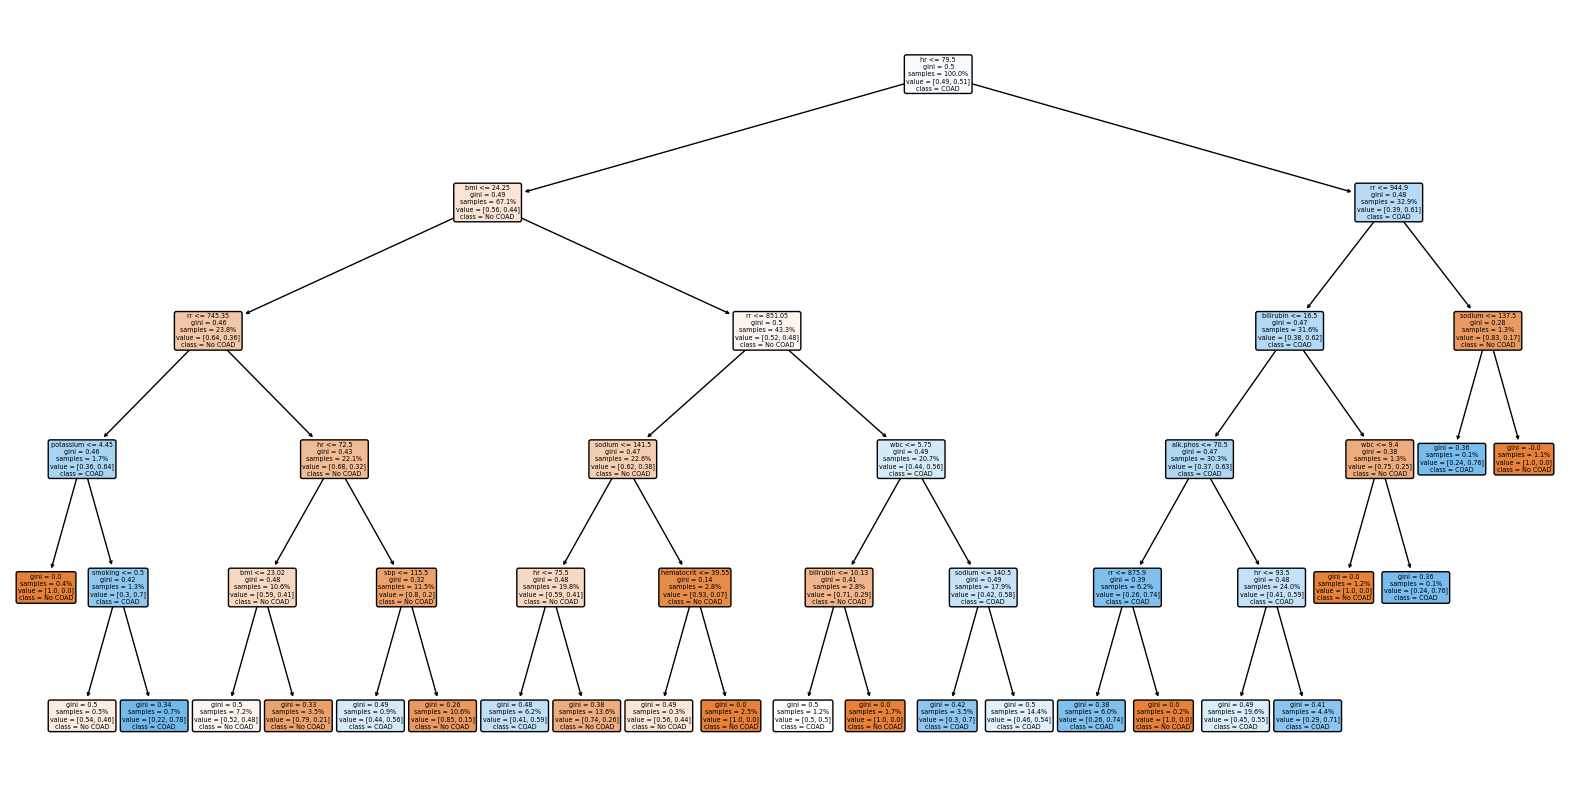

In [5]:
#Graficamos uno de los árboles de decisión del random forest, Se accede a él con el atributo estimators_
plt.figure(figsize=(20,10))
plot_tree(best_model.estimators_[2],  # plotea el tercer árbol
          feature_names= list(labels),  
          class_names=['No COAD', 'COAD'],  # nombres de las clases
          filled=True,  # colorear nodos por clase
          rounded=True,  # bordes redondeados
          precision=2, # precisión decimal
         proportion = True)  # Al usar pesos es mejor usar proporción para ver los valores de samples y values
plt.show()

## XGboost

XGBoost (eXtreme Gradient Boosting) representa una evolución en los algoritmos de ensemble, diferenciándose del Random Forest en su aproximación fundamental al aprendizaje. Mientras Random Forest construye árboles independientes en paralelo y promedia sus predicciones, **XGBoost construye árboles secuencialmente**, donde cada nuevo árbol intenta corregir los errores de los árboles anteriores mediante un proceso de optimización de gradiente.

La principal ventaja de XGBoost sobre Random Forest radica en su capacidad de aprendizaje adaptativo y su robusto sistema de regularización, que ayuda a prevenir el overfitting. Entre los hiperparámetros mas importantes se encuentra el **eta/learning rate, el num_boost_round y early_stopping_round**; estos nos ayudaran a controlar el overfitting del modelo. Se puede obtener un número óptimo de rondas hacinedo cross-validation, partiendo de un número máximo; posteriormente se pueden entrenar el modelo y finalmente realizar predicciones. A la hora de evaluar el número óptimo de rondas es necesario un conjunto de evaluación (diferente al trains y test set) por lo que se tendrían 3 subsets de datos utilizando la función train_test_split

Para mas información: https://xgboost.readthedocs.io/en/stable/get_started.html

In [6]:
####################################################################################################3

In [7]:
#Para XGboost utilizaremos validación cruzada y datos de la semana 8 a la 20, filtramos con el método isin()
df_xgb = df[df['week'].isin([8,12,16,20])]

#Eliminamos los Nan values en nuestras labels (variable coad)
df_xgb = df_xgb.dropna(subset=['coad']).copy()
target = 'coad'

# Queremos una clasificación binaria entonces convertimos todo número diferente a 0 en 1 con map()
X = df_xgb[variables]
y = df_xgb[target].map({1:1, 2:1, 3:1, 4:1, 5:1, 0:0})

#Convertimos variables categoricas en binarias
X['sex'] = X['sex'].map({'male': 1, 'female': 0})
X['trx'] = X['trx'].map({'Drug': 1, 'Placebo': 0})

imputer = SimpleImputer(strategy = 'median')
X_imputed =  imputer.fit_transform(X)

X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_imputed, y,
        test_size=0.30,
        random_state=42,
        stratify=y
)
# Separamos en conjunto de prueba y entrenamiento, es importante la estratificación por el desbalance de clases
X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=0.20,          # 0.20 de 0.70  ⇒  0.14 del total
        random_state=42,
        stratify=y_train_full
)

#XGboost acepta una matriz de datos especial que se obtiene con DMatrix; aquí también definimos las labels
dtrain = xgb.DMatrix(X_train,  label=y_train, feature_names=list(X.columns))
dval   = xgb.DMatrix(X_val,    label=y_val,   feature_names=list(X.columns))
dtest  = xgb.DMatrix(X_test,   label=y_test,  feature_names=list(X.columns))

In [8]:
# parámetros estandar, la metrica es la AUC de la curva ROC
#la función obetivo binary:logistic permite obtener probabilidad (valor continuo) de pertenencia a una clase 
params = {
    'objective': 'binary:logistic',  # clasificación binaria con probabilidades, nos da la probabilidad de pertenencia a una clase
    'eval_metric': 'aucpr',         # métrica robusta para desbalanceo (Area bajo la curva Precicion-Recall)
    'max_depth': 5,                 # árboles poco profundos para evitar overfitting
    'eta': 0.05,                    # tasa de aprendizaje baja
    'subsample': 0.8,               # muestreo de observaciones
    'colsample_bytree': 0.8,        # muestreo de features
    'scale_pos_weight': 13,         # peso para clase minoritaria (ratio neg/pos)
    'gamma': 0.8
}

num_boost_round = 1000 # definimos este extremo

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round, #Número máximo de rondas si no hay early stopping de 1000
    nfold=5,
    stratified=True, #Siempre la estratificación por el desbalance de clases
    early_stopping_rounds= 50, #si despues de 50 rondas no hay mejoría se detiene la validación cruzada
    as_pandas=True 
)

In [9]:
#Imprimimos el score de los últimos arboles entrenados
print(cv_results.tail())

#Imprimimos el mayor auc_score y el número optimo de rondas (y por ende árboles) generados
best_auc = cv_results['test-aucpr-mean'].max()
best_round = cv_results['test-aucpr-mean'].idxmax()
print(f"\nMejor puntaje AUC en la validación cruzada: {best_auc:.4f}")
print(f"Número óptimo de rondas (árboles): {best_round}")

    train-aucpr-mean  train-aucpr-std  test-aucpr-mean  test-aucpr-std
66          0.675065         0.029941         0.114192        0.011180
67          0.677483         0.031286         0.114525        0.011188
68          0.678259         0.031160         0.114154        0.011119
69          0.681838         0.030162         0.111879        0.009003
70          0.683703         0.030490         0.115420        0.011129

Mejor puntaje AUC en la validación cruzada: 0.1154
Número óptimo de rondas (árboles): 70


In [10]:
#Entrenamos al modelo con los parámetros y 
final_model = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=50,
    num_boost_round=best_round
)


[0]	train-aucpr:0.14382	test-aucpr:0.10217
[1]	train-aucpr:0.19286	test-aucpr:0.10916
[2]	train-aucpr:0.22372	test-aucpr:0.10437
[3]	train-aucpr:0.25157	test-aucpr:0.09710
[4]	train-aucpr:0.25536	test-aucpr:0.09559
[5]	train-aucpr:0.29283	test-aucpr:0.10282
[6]	train-aucpr:0.33737	test-aucpr:0.09813
[7]	train-aucpr:0.34843	test-aucpr:0.10064
[8]	train-aucpr:0.36110	test-aucpr:0.10383
[9]	train-aucpr:0.37559	test-aucpr:0.10658
[10]	train-aucpr:0.39626	test-aucpr:0.10567
[11]	train-aucpr:0.40922	test-aucpr:0.10207
[12]	train-aucpr:0.42138	test-aucpr:0.10624
[13]	train-aucpr:0.43077	test-aucpr:0.10523
[14]	train-aucpr:0.43821	test-aucpr:0.09946
[15]	train-aucpr:0.43568	test-aucpr:0.09590
[16]	train-aucpr:0.44547	test-aucpr:0.09683
[17]	train-aucpr:0.46004	test-aucpr:0.09682
[18]	train-aucpr:0.45929	test-aucpr:0.09717
[19]	train-aucpr:0.46287	test-aucpr:0.09839
[20]	train-aucpr:0.46903	test-aucpr:0.10232
[21]	train-aucpr:0.48004	test-aucpr:0.10283
[22]	train-aucpr:0.48580	test-aucpr:0.1044

In [11]:
#Para evaluar las predicciones importamos classification report y confussion_matrix
from sklearn.metrics import classification_report, confusion_matrix

#Hacemos las predicciones, acordemonos que con 'Binary: Logistic' vamos a optener probabilidades
#Esto hay que convertirlo a predicciones discretas 0- Auscencia de COAD ; 1-Presencia de COAD
pred_proba = final_model.predict(dtest)


# Convertir a clases (0 o 1).... se puede jugar con el treshold de predicción
y_pred = (pred_proba > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.85      2201
           1       0.11      0.32      0.16       173

    accuracy                           0.75      2374
   macro avg       0.52      0.55      0.51      2374
weighted avg       0.88      0.75      0.80      2374

[[1730  471]
 [ 117   56]]


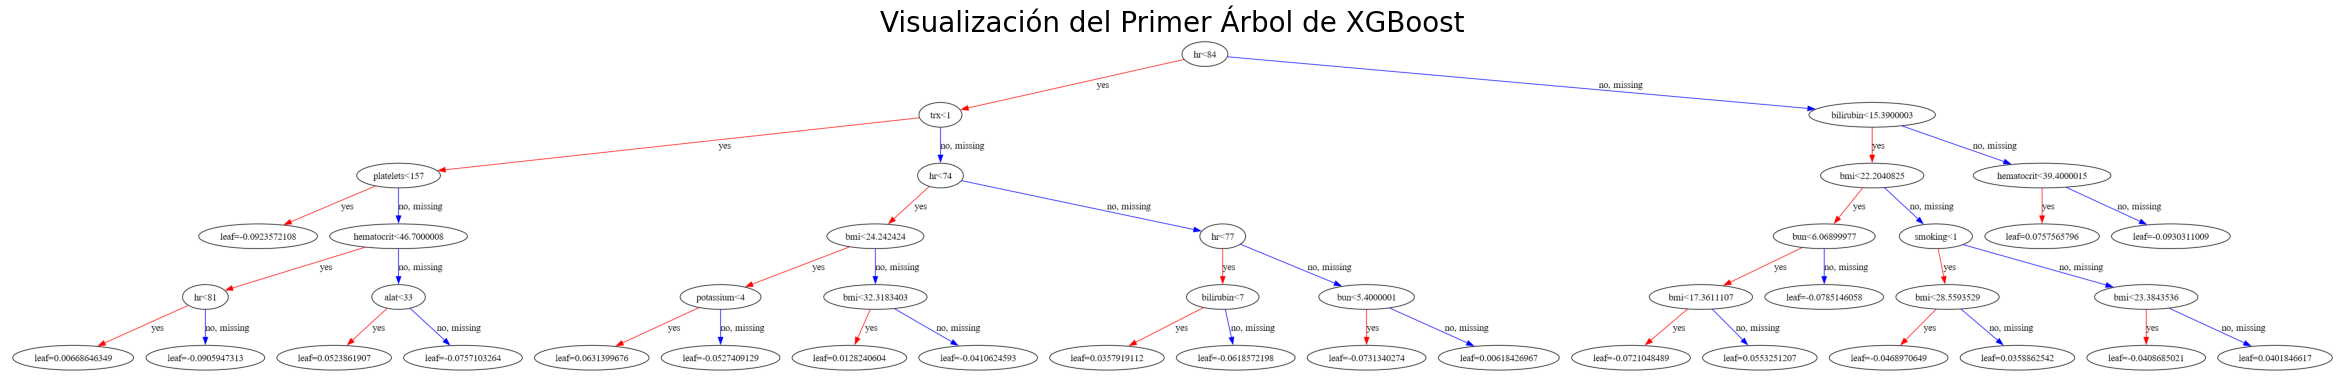

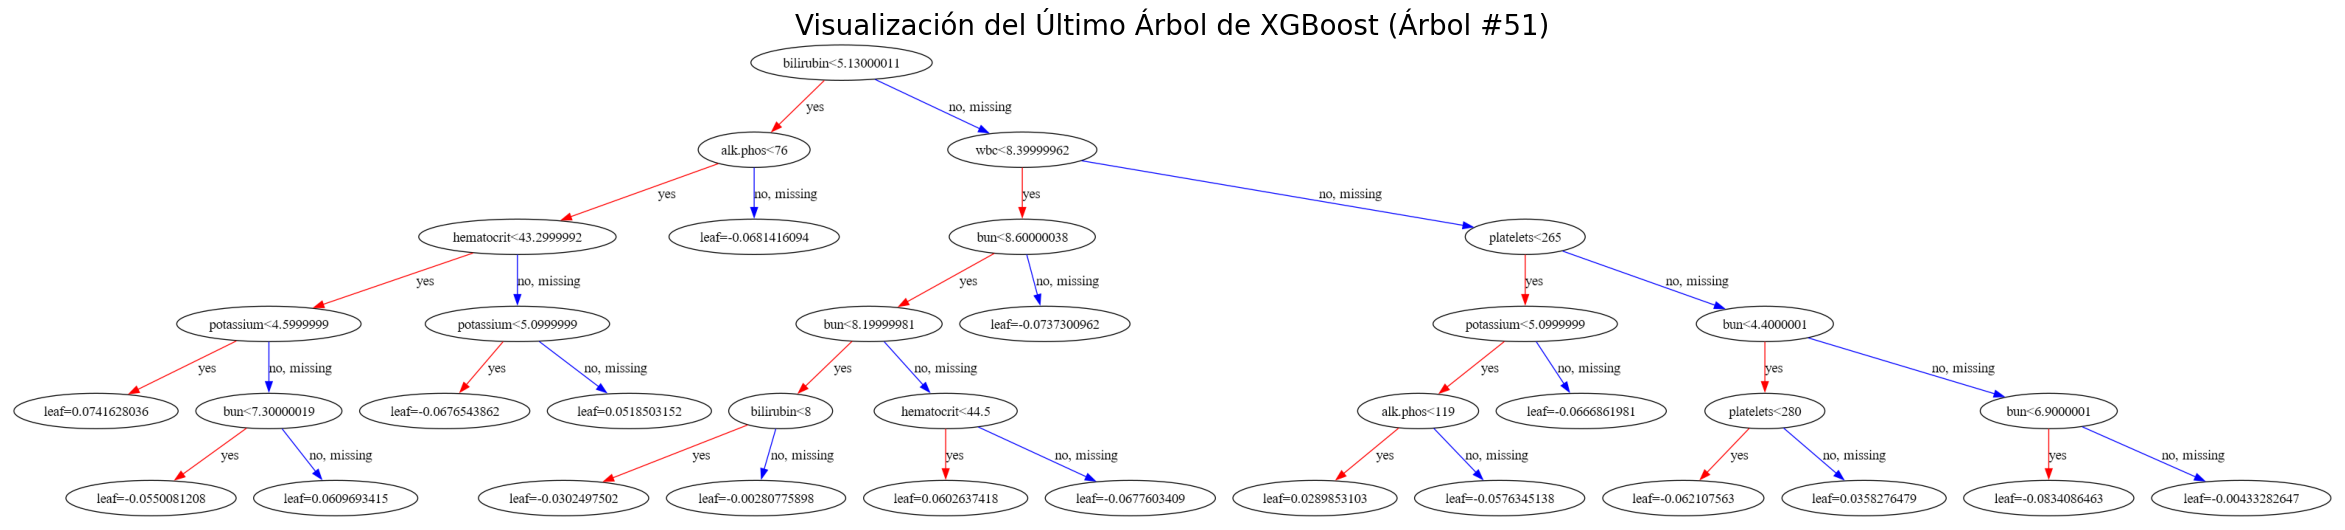

In [12]:


import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico para que sea legible
plt.rcParams['figure.figsize'] = [30, 15] # Ancho, Alto 

# Graficar el primer árbol (num_trees = 0)
xgb.plot_tree(final_model, num_trees=0)
plt.title("Visualización del Primer Árbol de XGBoost", fontsize=20)
plt.show()

# Graficar el último árbol que se añadió
# El número de árboles está en final_model.num_boosted_rounds()
ultimo_arbol_idx = final_model.num_boosted_rounds() - 1
xgb.plot_tree(final_model, num_trees=ultimo_arbol_idx)
plt.title(f"Visualización del Último Árbol de XGBoost (Árbol #{ultimo_arbol_idx})", fontsize=20)
plt.show()

# Restablecer el tamaño de la figura a su valor por defecto si lo deseas
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

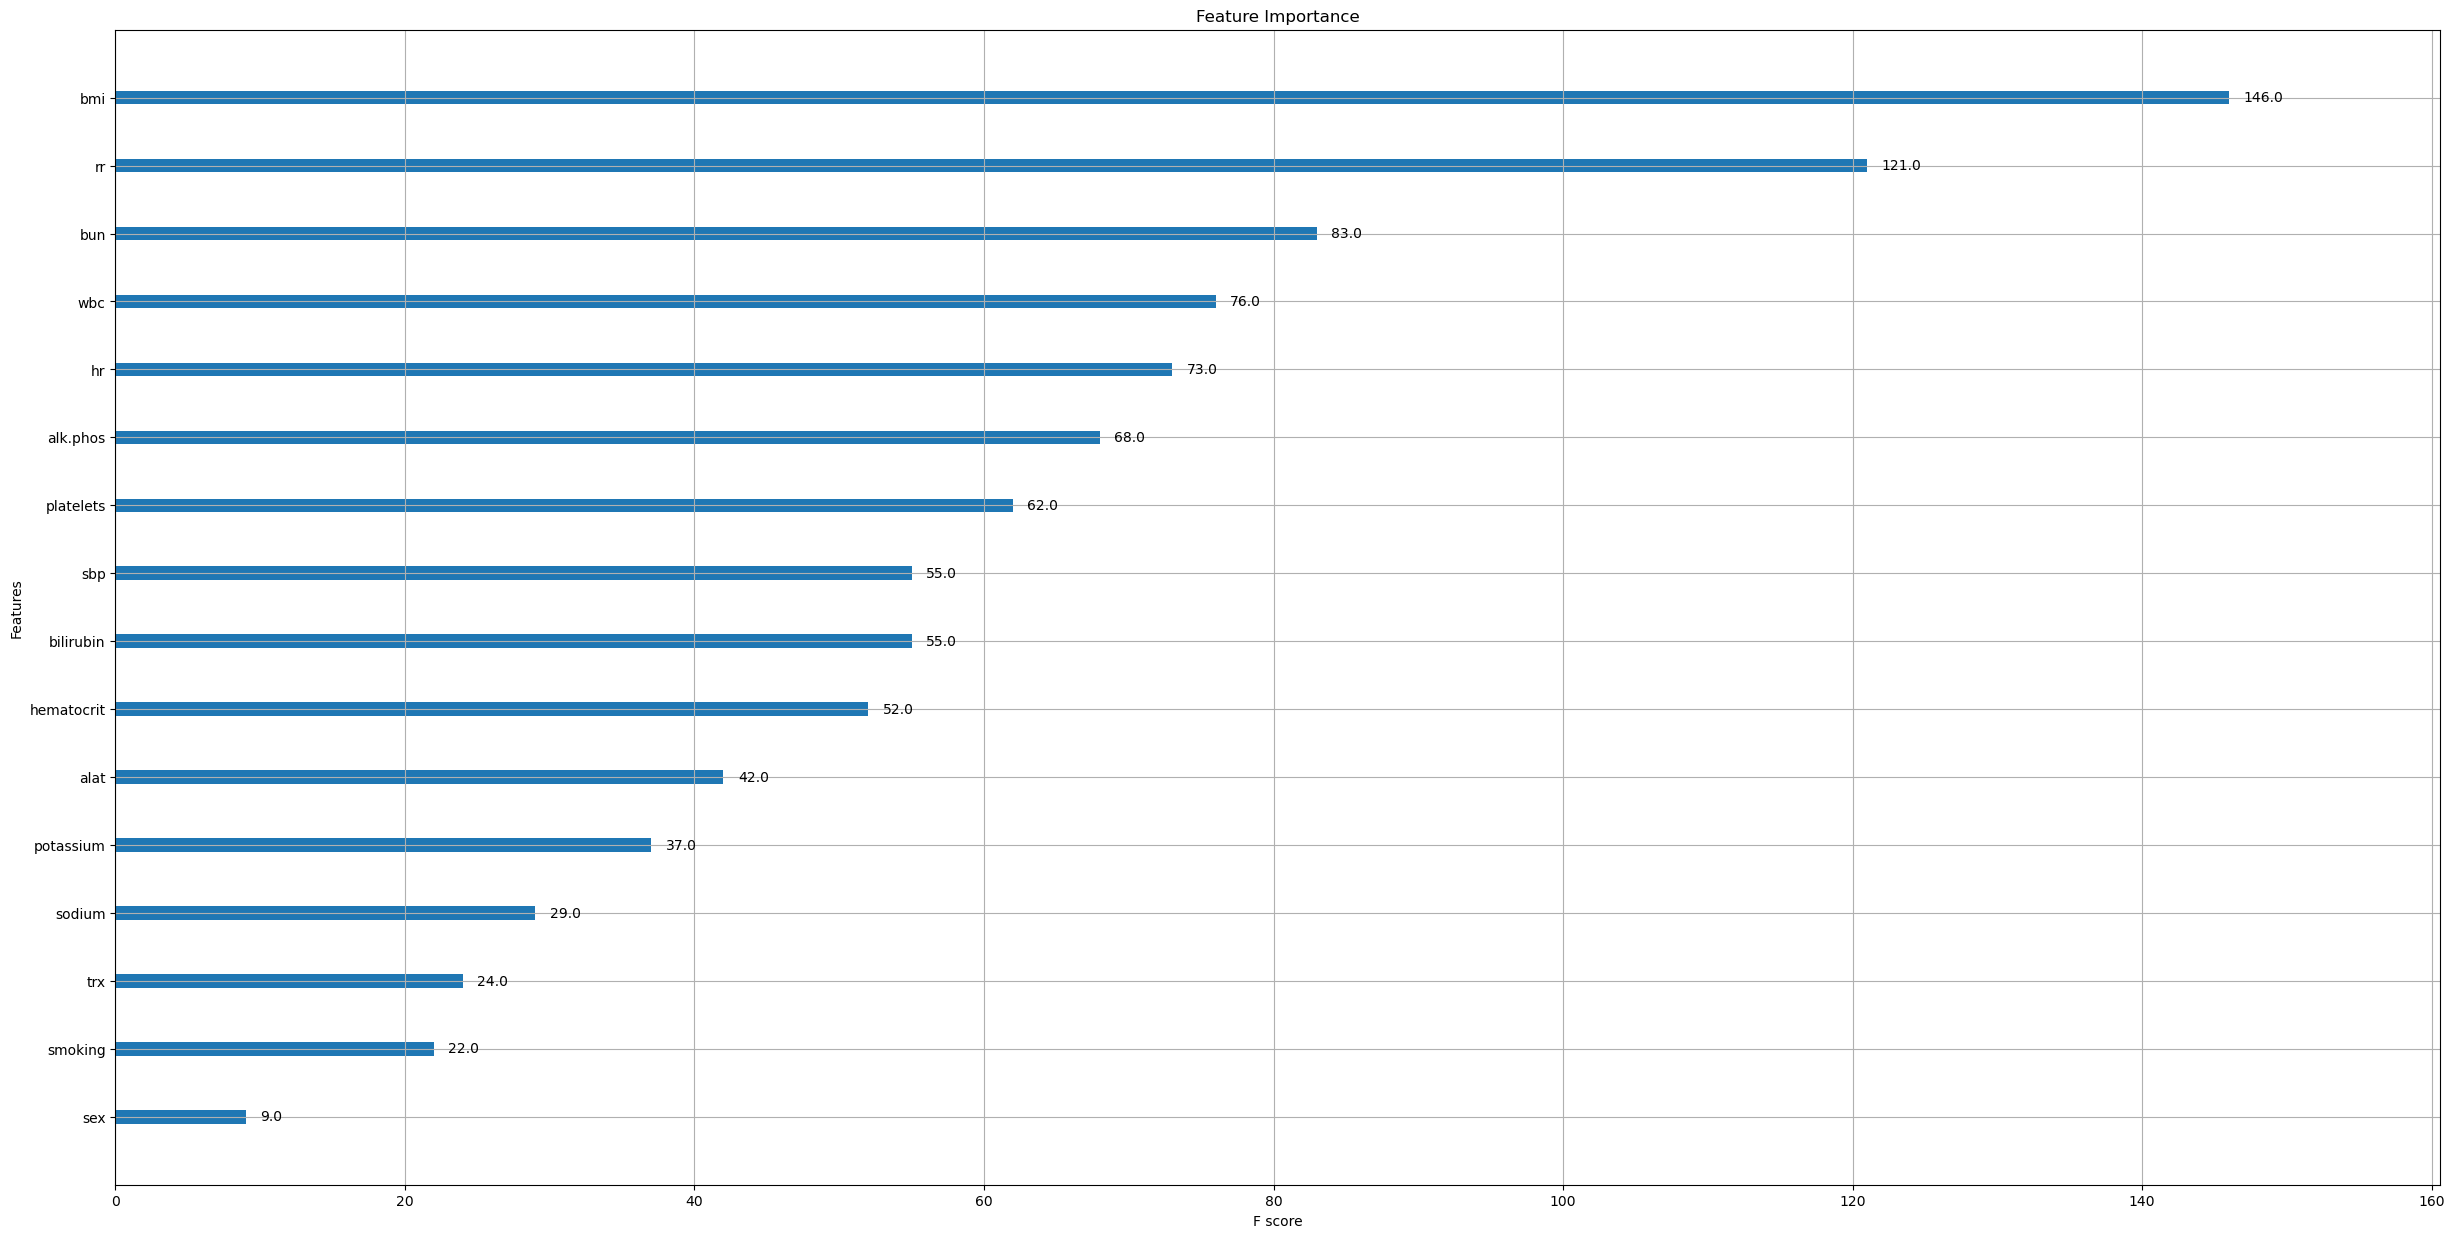

In [13]:
#Grafico de feature_importance con la función de plot_importance; importance type peude ser gain o weight
xgb.plot_importance(final_model, importance_type='weight')
plt.title('Feature Importance')
plt.show()

## Análisis de resultados de XGboost

Las métricas de evaluación son mejores que las del RandomForest pero distan de ser óptimas, se obtuvo un mejore recall y f1-score (0.32 y 0.16) para la clase positiva a expensas de la clase negativa, pero la tasa de falsos negativos y falsos positivos sigue siendo alta; es evidente que se necesitan otros métodos para mejorar las predicciones, en donde se sugiere disminuir el treshold de detección (automaticamnete está en 0.5) o hacer **feature engineering** para obtener mejores feaatures, sin embargo la gráfica obtenida con de feature importance nos permite observar que el modelo también utlizó variables similares al Random Forest como el **bmi, frecuencia respiratoria y conteo de celulas blancas**

Haremos una gráfica de Probabilidad de presentar COAD vs WBC para ver si existe cierta tendencia en los datos y las probabilidades obtenidas por el modelo; para esto necesitamos crear un nuevo df usando indexación en pandas y graficas con seaborn, como hemos venido haciendo.

In [14]:
#Un loop para enumerar índice-columna para poder ubicarlos mejor, se utiliza enumerate
for i, columna in enumerate (X.columns):
    print(f"Columna '{columna}' está en el índice {i}")



Columna 'potassium' está en el índice 0
Columna 'bun' está en el índice 1
Columna 'alat' está en el índice 2
Columna 'bilirubin' está en el índice 3
Columna 'hematocrit' está en el índice 4
Columna 'sodium' está en el índice 5
Columna 'alk.phos' está en el índice 6
Columna 'platelets' está en el índice 7
Columna 'wbc' está en el índice 8
Columna 'sbp' está en el índice 9
Columna 'rr' está en el índice 10
Columna 'sex' está en el índice 11
Columna 'hr' está en el índice 12
Columna 'smoking' está en el índice 13
Columna 'bmi' está en el índice 14
Columna 'trx' está en el índice 15


In [15]:
#Definimos columnas para crear un Nuevo df y facilitar el plot con seaborn
#Acordemonos que pred_proba son las probabilidades de presentar o no coad
wbc_count = X_test[:,8] 
smoking = X_test[:,13]
trx = X_test[:,15]
bmi = X_test[:,14]
rr = X_test[:,10]

#Creamos un df para hacer scatterplots y ver algunas relaciones entre variables
scatter_df = pd.DataFrame({'wbc': wbc_count, 'bmi' : bmi, 'coad_prob': pred_proba, 'smoking' : smoking, 'trx': trx, 'rr':rr})

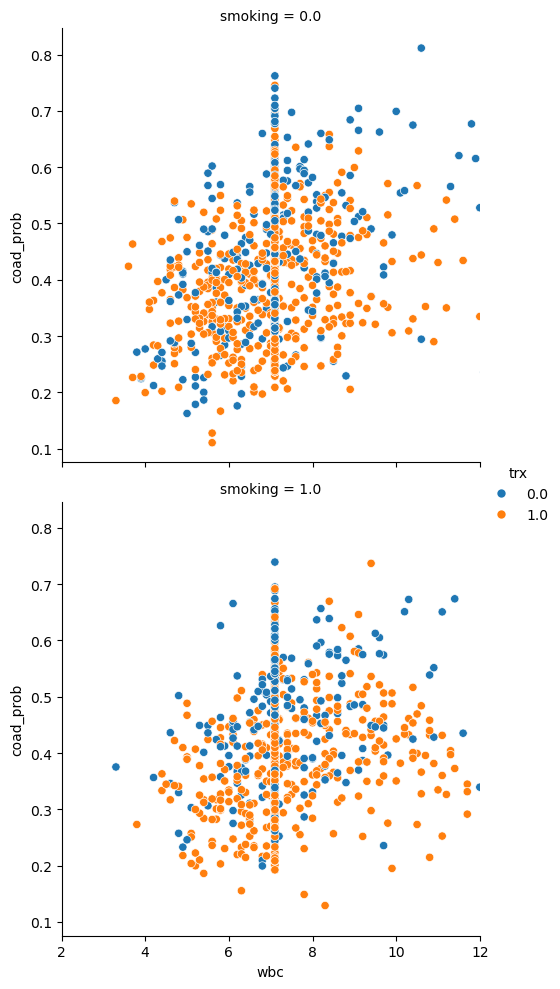

In [16]:
# Grafica probabilidad de Coad vs WBC
sns.relplot(
    data=scatter_df,
    x='wbc',
    y='coad_prob',
    row='smoking',
    hue='trx',
    kind='scatter'
)
plt.xlim(2, 12)
plt.show()

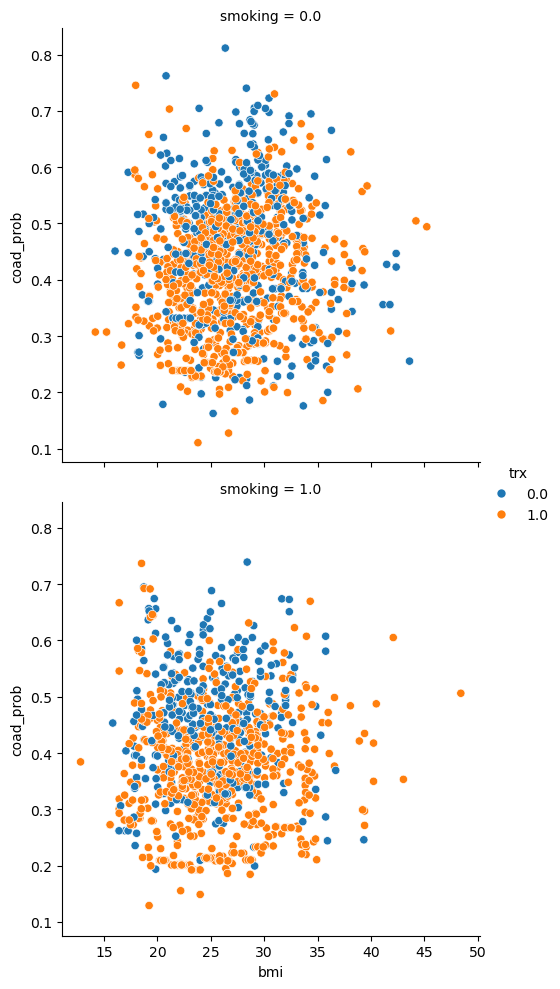

In [17]:
#Gráfica probabilidad de COAD vs BMI
sns.relplot(
    data=scatter_df,
    x='bmi',
    y='coad_prob',
    row='smoking',
    hue='trx',
    kind='scatter'
)
plt.show()

# Conclusiones

* En ambas gráficas se observa una **correlación positiva entre el wbc y el bmi y la probabilidad de exacerbación de 'coad'**, sin embargo no se encontró un algoritmo que nos permitiera predecir la aparición de estas exacerbaciones. 

* Es posible que existan **otras variables**, no tomadas en cuenta tanto por este análisis como por la farmacúetica que realizó el estudio, que puedan brindar mas información; también se suma la **gran cantidad de Nan Values**, debido a la dificultad de seguimiento de los pacientes en estos ensayos clínicos extensos; finalmente, es probable que el medicamento evaluado trate algun factor de riesgo como la insuficiencia cardiaca, la apnea del sueño o la ansiedad/depresión y esto explique la mayor aparición de exacerbaciones en el grupo placebo.

* No obstante el **feature importance y las graficas de los árboles de decisión aislados** permiten observar que variables como la frecuencia respiratoria, el conteo de células blancas y el BMI fueron importantes para tomar las decisiones

* Es posible replicar el mismo análisis con otros efectos adversos, por ejemplo con el Cluster Gastrointestinal obtenido en el Notebook anterior y observar tendencias